In [1]:
! eups list -s lsst_distrib

   22.0.1-3-g7ae64ea+78f87bf5bb 	w_latest w_2021_51 current setup


In [2]:
import sys
sys.path.append("/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python")

In [3]:
import numpy
import pylab as plt

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from mixcoatl.characterizeSpots import CharacterizeSpotsTask
from mixcoatl.gridFitTask import GridFitTask

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python/mixcoatl/characterizeSpots.py:136: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def run(self, exposure, exposureIdInfo=None):


In [147]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [5]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/"
butler = Butler(repo_path)

In [6]:
collections="u/youtsumi/Run5/run_R02_S00/spot"
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [7]:
print(registry)

PostgreSQL@rubin:bot_data_w_2021_43


In [8]:
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/calib/unbounded
LSSTCam/raw/all
LSSTCam/photodiode/all
u/snyder18/crosstalk_13169/sbias/20211215T191900Z
u/snyder18/crosstalk_13175/sbias/20211217T211636Z
u/snyder18/crosstalk_13186/sbias/20211217T225138Z
u/snyder18/crosstalk_13169/crosstalk_spot/20211218T003408Z
u/snyder18/crosstalk_13175/crosstalk_spot/20211218T225100Z
u/snyder18/crosstalk_13186/crosstalk_spot/20211220T023605Z
u/snyder18/crosstalk_13198/sbias/20211220T182307Z
u/snyder18/crosstalk_13200/sbias/20211220T215856Z
u/snyder18/crosstalk_13200/crosstalk_spot/20211220T223117Z
u/snyder18/crosstalk_13224/sbias/20211221T223805Z
u/snyder18/crosstalk_13224/crosstalk_spot/20211221T224715Z
u/abrought/run_13141/sbias/20211223T071924Z
u/abrought/run_13141/sflat/20211223T080759Z
u/youtsumi/Run5/run_R02_S00/sbias/20211223T171539Z
u/youtsumi/Run5/run_R02_S00/sbias/20211223T180251Z
u/youtsumi/Run5/run_R02_S00/sbias/20211223T180452Z
u/youtsumi/Run5/run_R02_S00/sdark/20211223T183026Z
u/abrought/run_13141/sflat/20211223T183057Z
u/yout

In [9]:
collections = 'u/youtsumi/Run5/run_R02_S00/spot'
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

0 DatasetType('camera', {instrument}, Camera, isCalibration=True)
3121353 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('photodiode', {band, instrument, physical_filter, exposure}, AstropyTable)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
700 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
0 DatasetType('cpCrosstalkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('crosstalkBackgroundZOffsets', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
0 DatasetType('crosstalkBackgroundYTilts', {band, instru

In [17]:
where = """
instrument='LSSTCam'
and detector=9
and exposure.observation_type = 'spot'
and exposure.science_program IN ('13230','13231')
"""

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections,
    where=where)
                  )
results = []

for aref in datasetRefs[:]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        if img.min()<22000:
            raise
        md = raw.getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
#        raise
        pass

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211222/MC_C_20211222_000619/MC_C_20211222_000619_R02_S00.fits(MC_C_20211222_000619): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211222/MC_C_20211222_000619/MC_C_20211222_000619_R02_S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211222/MC_C_20211222_001140/MC_C_20211222_001140_R02_S00.fits(MC_C_20211222_001140): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211222/MC_C_20211222_001140/MC_C_20211222_001140_R02_S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211222/MC_C_20211222_000846/MC_C_20211222_000846_R02_S00.fits(MC_C_20211222_000846): Unable to determine the filter
/sdf/group/

In [ ]:
from astropy.table import vstack, join
faint = []
for aresult in results:
    if aresult["md"]["EXPTIME"]>13:
        continue
    faint.append(aresult["src"].asAstropy())
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0) &
        (mean_data_table["base_PixelFlags_flag"]==False) &
        (mean_data_table["base_PsfFlux_flag"]==False) &
        (mean_data_table["base_SdssCentroid_flag"]==False) &
        (mean_data_table["base_CircularApertureFlux_70_0_flag_apertureTruncated"]==False) &
        (mean_data_table["spotgrid_x"]<3800) &
        (mean_data_table["spotgrid_y"]<3800) &
        (mean_data_table["spotgrid_x"]>200) &
        (mean_data_table["spotgrid_y"]>200)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_51/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<Table length=2400>
   id   coord_ra coord_dec  parent base_SdssCentroid_x base_SdssCentroid_y ... base_FootprintArea_value     spotgrid_y         spotgrid_x     spotgrid_normalized_dy  spotgrid_normalized_dx spotgrid_index
          rad       rad                    pix                 pix         ...           pix                                                                                                               
float64 float64   float64  float64       float64             float64       ...         float64               float64            float64              float64                 float64             int32     
------- -------- --------- ------- ------------------- ------------------- ... ------------------------ ------------------ ------------------ ---------------------- ----------------------- --------------
    2.0      nan       nan     0.0  1660.1722902589481  1317.2704469288374 ...                    317.0 1316.2391509347638 1659.3292459867212   0.013940287308393029    0.012422792489705667              0
   14.0      nan       nan     0.0  1653.9510420451481   1383.042792978244 ...                    317.0 1381.9566464964691 1653.1712227956243   0.014469872165643589    0.011374228297770458              1
   35.0      nan       nan     0.0   1647.804200883294  1448.5919281319943 ...                    317.0 1447.6906553989302 1647.0939940612695   0.011082858308522707    0.011106353707439244              2
   69.0      nan       nan     0.0  1641.6491874406681  1514.1805230654222 ...                    317.0 1513.3401083966648 1640.9748701441554   0.010884211025264557    0.009440682006551175              3
  105.0      nan       nan     0.0  1635.4796538045246  1579.9269340731144 ...                    317.0  1579.048964038654 1634.8932008488118   0.010830653302217021    0.009337473308380874              4
  143.0      nan       nan     0.0   1629.409071816293  1645.3952071764356 ...                    317.0 1644.7449257994724 1628.8049326628748   0.007472263378561073     0.00921422711846747              5
  180.0      nan       nan     0.0   1623.255846233257  1711.1409589822717 ...                    317.0 1710.4246135694843 1622.7088459563902   0.008232820202310323    0.008619253282886912              6
  218.0      nan       nan     0.0  1617.2550928696605  1776.7096833843755 ...                    317.0 1776.1083033941022 1616.6125305896317   0.006353353657279699    0.009711473457681015              7
  256.0      nan       nan     0.0  1611.0924467921534  1842.3333830362578 ...                    317.0   1841.79199321872  1610.516628314584   0.005683901245144616    0.008682348293062544              8
  294.0      nan       nan     0.0  1605.0445896270387  1908.1113399091626 ...                    317.0 1907.4829198764726 1604.4325677786198   0.007168687042047761    0.009322527518141529              9
  332.0      nan       nan     0.0  1599.0801350062393    1973.44279896937 ...                    317.0 1973.1777840199934 1598.3517363078658  0.0015423968832107334    0.010602954366866063             10
  370.5      nan       nan     0.0   1592.777927260107  2039.3115447667265 ...                    317.0 2038.8615257936121 1592.2554363392528    0.00453436815254193   0.0076638664825366175             11
  409.0      nan       nan     0.0  1586.7269991695107  2104.8771148819087 ...                    317.0 2104.5452675672313 1586.1607763339307  0.0028463921723904948    0.008109426431698135             12
  447.0      nan       nan     0.0  1580.5488831611212   2170.658222729982 ...                    317.0   2170.22900934085  1580.068110075401   0.004482104820677742   0.0071354950113855335             13
  124.0      nan       nan     0.0  1578.0029133258713  205.67750718365053 ...                    317.0 205.41160892077426 1577.8232946690434   0.003856238184211238    0.004706690952353651             14
  162.0      nan       nan     0.0  1571.8831155529483   271.3328418528395 ...                    317.0 

In [39]:
exparray = numpy.array([ aresult["md"]["EXPTIME"] for aresult in results ])

In [40]:
exparray[ numpy.argmin(exparray) ]

1.25

[]

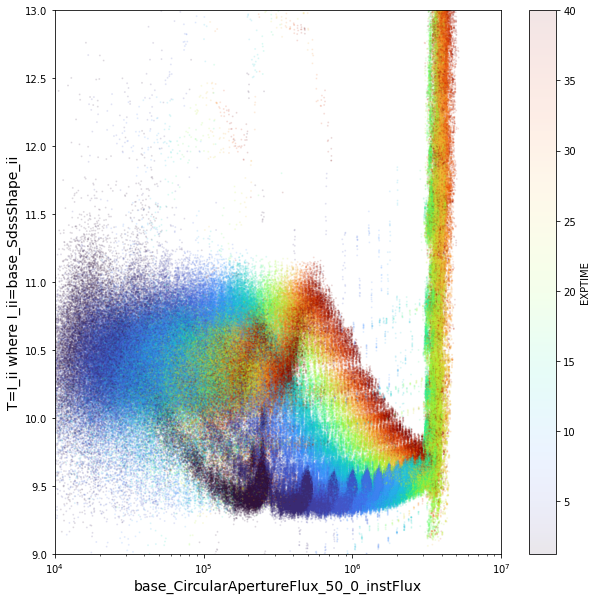

In [19]:
fontsize=14
fig = plt.figure(figsize=(10,10))

#ykey="ext_shapeHSM_HsmShapeRegauss_sigma"
ykey="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="base_CircularApertureFlux_50_0_instFlux"
#xkey="base_SdssShape_instFlux"
x = []
y = []
e = []
for aresult in results[:]:
    cond = aresult["src"]["spotgrid_index"]>=0
    x.extend(aresult["src"][xkey][cond])
    y.extend((aresult["src"][ykey]+aresult["src"][y2key])[cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
plt.scatter(x,y,c=e,s=1,cmap='turbo',alpha=0.1)
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("{}".format("T=I_ii where I_ii=base_SdssShape_ii"),fontsize=fontsize)
plt.xlim(1e4,1e7)
plt.ylim(9,13)
#plt.ylim(1e4,1e8)
plt.colorbar(label="EXPTIME")
#plt.loglog()
plt.semilogx()

In [70]:
from astropy.table import vstack, join
faint = [ results[i]["src"].asAstropy() for i in  numpy.where(exparray == exparray[ numpy.argmin(exparray) ] )[0] ]
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0) &
        (mean_data_table["base_PixelFlags_flag"]==False) &
        (mean_data_table["base_PsfFlux_flag"]==False) &
        (mean_data_table["base_SdssCentroid_flag"]==False) &
        (mean_data_table["base_CircularApertureFlux_70_0_flag_apertureTruncated"]==False) &
        (mean_data_table["spotgrid_x"]<3800) &
        (mean_data_table["spotgrid_y"]<3800) &
        (mean_data_table["spotgrid_x"]>200) &
        (mean_data_table["spotgrid_y"]>200)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

<Table length=1938>
   id   coord_ra coord_dec  parent base_SdssCentroid_x base_SdssCentroid_y ... base_FootprintArea_value     spotgrid_y         spotgrid_x      spotgrid_normalized_dy  spotgrid_normalized_dx spotgrid_index
          rad       rad                    pix                 pix         ...           pix                                                                                                                
float64 float64   float64  float64       float64             float64       ...         float64               float64            float64               float64                 float64             int32     
------- -------- --------- ------- ------------------- ------------------- ... ------------------------ ------------------ ------------------ ----------------------- ----------------------- --------------
  438.0      nan       nan     0.0    1616.03778913253   2504.789813391265 ...                    317.0 2518.8221564176847  1607.322787514937    -0.22498804106415585     0.10991306437372539             17
  479.0      nan       nan     0.0  1609.9527671515134  2570.4112866814917 ...                    317.0  2553.514465463541 1604.0960041885453     0.24761339636031862     0.10681690687520688             18
  516.5      nan       nan     0.0  1603.8786668369767  2636.0791550842823 ...                    317.0  2619.205484764035 1598.5435384755096     0.24779380933024406      0.1139412728811022             19
  553.0      nan       nan     0.0  1597.8150065733641  2701.7723199281922 ...                    317.0 2680.4099680105974 1584.4337746112915      0.2469614653875786      0.2589299281231618             20
  590.0      nan       nan     0.0  1591.8159687542936   2767.336648473713 ...                    317.0  2746.045826763481  1578.902063617437   0.0045723918165057765      0.2565723196899556             21
  628.0      nan       nan     0.0  1585.6100783766087   2832.971070083901 ...                    317.0 2811.7536615275517 1573.3703526235827   0.0050170246910363975      0.2518549276522049             22
  666.0      nan       nan     0.0   1579.860725928795  2898.5624282143804 ...                    317.0  2877.461496291623 1567.8081903827208   0.0026173909628591507      0.2527687948483521             23
  704.0      nan       nan     0.0  1573.5531438452915   2964.280852802044 ...                    317.0 2943.1693310556943 1562.2764826301598    0.004409047522947487     0.24640842979625938             24
  742.0      nan       nan     0.0  1567.6379036609683   3029.915083841747 ...                    317.0  3008.877165819765 1556.7447748775987 -6.7923680783121045e-06     0.24649620499344965             25
  780.0      nan       nan     0.0    1561.40220698266  3095.4680242916456 ...                    317.0 3074.5850005838365 1551.2130671250377   0.0023181065236420016     0.24071946425214658             26
  556.0      nan       nan     0.0  1571.2224038954976   999.1944577164925 ...                    317.0 1002.1177558347074 1545.6699111795954     -0.0770003863292346     0.38254923179592504             27
  594.5      nan       nan     0.0  1564.8734725412528  1064.8212165834923 ...                    317.0 1067.9410158011056 1540.0964549362036    -0.07843314367182258     0.30493865197696446             28
  632.0      nan       nan     0.0  1559.1616483014957  1130.4531023558836 ...                    317.0 1133.5642309629543 1534.5835527689635    -0.07825110960716955     0.36735907033818627             29
  669.0      nan       nan     0.0  1552.9440947397675  1195.8705469301308 ...                    317.0 1199.3232230298945 1529.0512098671231     -0.0825266454412658      0.3565606035194872             30
  336.5      nan       nan     0.0   1699.927409829556  2313.7616721965483 ...                    317.0 2294.1231451721414  1688.040184001163     0.28026535018305343     0.20362640518800817             63
  371.0      nan       nan     0.0   1693.983195188207   2379.500886679415 ...       

<Figure size 720x720 with 0 Axes>

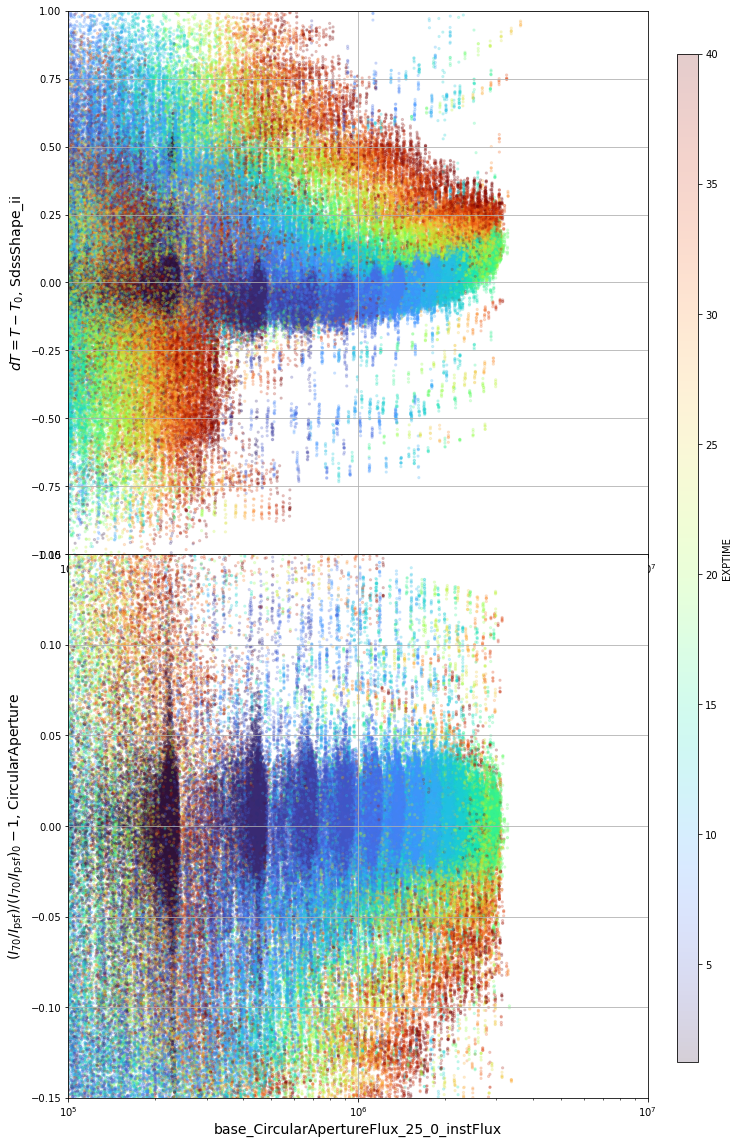

In [122]:
fig = plt.figure(figsize=(10,10))

from astropy.table import vstack, join

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
#xkey="base_CircularApertureFlux_70_0_instFlux"
xkey="base_CircularApertureFlux_25_0_instFlux"
zskey="base_CircularApertureFlux_3_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

  
x = []
y = []
zl = []
zs = []
e = []
for aresult in results[:]:
    joined = join(aresult["src"].asAstropy(),ref,keys="spotgrid_index")
    Iperr = joined["base_PsfFlux_instFluxErr_1"]
    Ip = joined["base_PsfFlux_instFlux_1"]    
    Ierr = joined["{}Err_1".format(xkey)]
    I = joined["{}_1".format(xkey)]    
    joined = joined[
        numpy.where( 
            (joined["base_PixelFlags_flag_1"] == False) &
            (joined["base_PsfFlux_flag_edge_1"] == False) &
            (joined["base_CircularApertureFlux_70_0_flag_apertureTruncated_1"] == False) &            
            (joined["base_ClassificationExtendedness_flag_1"] == False) &
            (joined["base_PixelFlags_flag_1"] == False) &            
            (joined["base_PixelFlags_flag_offimage_1"] == False) &
            (joined["base_PixelFlags_flag_edge_1"] == False) &
            (joined["base_PixelFlags_flag_interpolated_1"] == False) &
            (joined["base_PixelFlags_flag_saturated_1"] == False) &            
            (joined["base_PixelFlags_flag_cr_1"] == False) &
            (joined["base_PixelFlags_flag_bad_1"] == False) &
            (joined["base_PixelFlags_flag_suspect_1"] == False) &
            (joined["base_PixelFlags_flag_interpolatedCenter_1"] == False) &
            (joined["base_PixelFlags_flag_saturatedCenter_1"] == False) &
            (joined["base_PixelFlags_flag_crCenter_1"] == False) &
            (joined["base_PixelFlags_flag_suspectCenter_1"] == False) &
            (joined["spotgrid_x_1"] > 500 ) &
            (joined["spotgrid_y_1"] > 500 ) &
            (joined["spotgrid_x_1"] < 3500 ) &
            (joined["spotgrid_y_1"] < 3500 ) &
            (Iperr/Ip<0.01)&
            (Ierr/I<0.01)            
        )
    ]
    x.extend(joined["{}_1".format(xkey)])
    Y1=joined["{}_1".format(y1key)]
    Y2=joined["{}_1".format(y2key)]
    Y0_1=joined["{}_2".format(y1key)]
    Y0_2=joined["{}_2".format(y2key)]    
    zl.extend(joined["{}_1".format(zlkey)]/joined["{}_2".format(zlkey)])
    zs.extend(joined["{}_1".format(zskey)]/joined["{}_2".format(zskey)])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([aresult["md"]["EXPTIME"]]*len(Y1))
    
x=numpy.array(x)
y=numpy.array(y)
zl=numpy.array(zl)
zs=numpy.array(zs)

fig = plt.figure(figsize=(10,20))

ax = plt.subplot(211)
sca=ax.scatter(x,y,c=e,s=5,cmap='turbo',alpha=0.2)
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
ax.set_xlim(1e5,1e7)
ax.set_ylim(-1,1)
ax.grid()

bx = plt.subplot(212,sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=5,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
bx.set_xlim(1e5,1e7)
bx.set_ylim(-.15,.15)
plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.93,hspace=0)

(array([  0,   3,   4,   9,  12,  13,  15,  18,  21,  24,  28,  30,  31,
        34,  36,  40,  41,  43,  47,  48,  51,  52,  54,  57,  59,  61,
        69,  70,  77,  78,  84,  89,  90,  91,  92,  93,  95,  96,  98,
        99, 107, 108, 109, 111, 115, 117, 121, 123, 124, 126, 131, 133,
       135, 138, 139, 141, 142, 145, 150, 152, 155, 157, 162, 165, 168,
       169, 170, 172, 178, 180, 181, 186, 189, 192, 196, 197, 200, 201,
       202, 203, 208, 209, 210, 211, 214, 223, 224, 225, 228, 230, 232,
       235, 241, 252, 255, 257, 258, 260, 261, 266, 268, 270, 271, 273,
       275, 276, 277, 280, 281, 282, 284, 285, 287, 288, 289, 294, 295,
       296, 297, 298, 299, 302, 304, 308, 310, 313, 316, 319, 320, 323,
       324, 326, 327, 328, 331, 332, 337, 339, 341, 345, 346, 348, 352,
       354, 366, 368, 369, 370, 374, 375, 377, 378, 380, 381, 383, 384,
       387, 388, 390, 391, 392, 396, 398, 399, 400, 401, 408, 409, 410,
       411, 412, 414, 417, 418, 423, 424, 426, 428, 430, 431, 4

Text(0.5, 0, 'EXPTIME [s]')

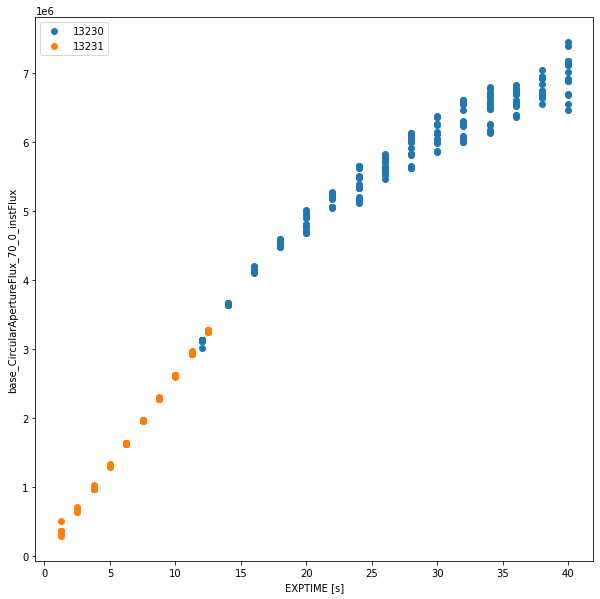

In [121]:
import pylab
fig = plt.figure(figsize=(10,10))

#for a in faint:
peak = []
exp = []
run = []
for b in results:
    peak.append(numpy.nanmax(b["src"]["base_CircularApertureFlux_70_0_instFlux"]))
    exp.append(b["md"]["EXPTIME"])
    run.append(b["md"]["RUNNUM"])

exp=numpy.array(exp)
peak=numpy.array(peak)
run=numpy.array(run)
for arun in list(set(run)):
    print(numpy.where(run == arun))
    pylab.plot(exp[numpy.where(run == arun)],peak[numpy.where(run == arun)],"o",label=arun)
pylab.legend()
pylab.ylabel("base_CircularApertureFlux_70_0_instFlux")
pylab.xlabel("EXPTIME [s]")

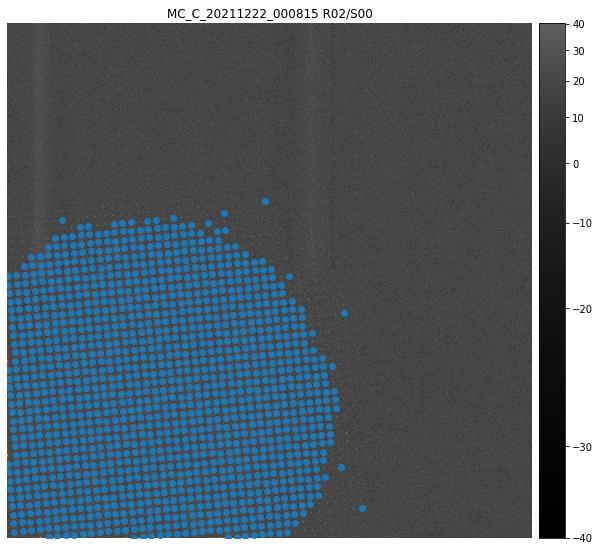

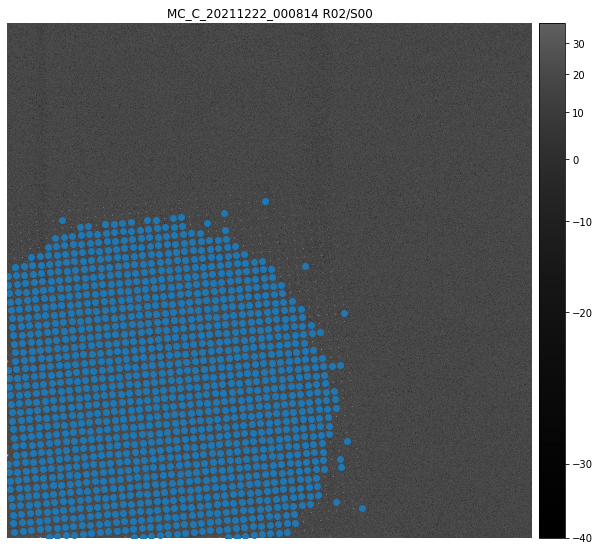

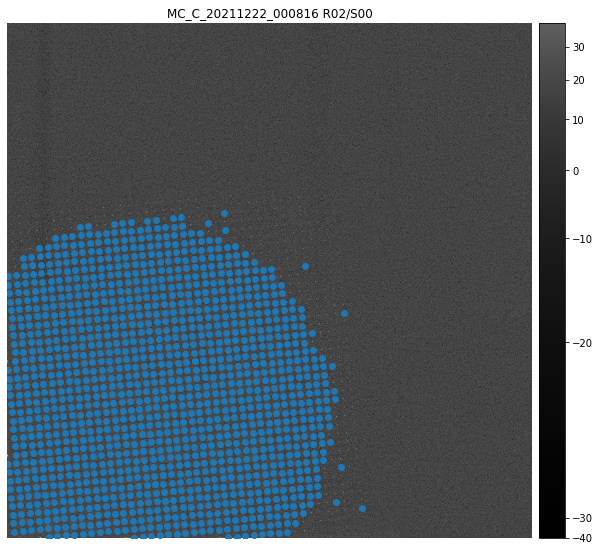

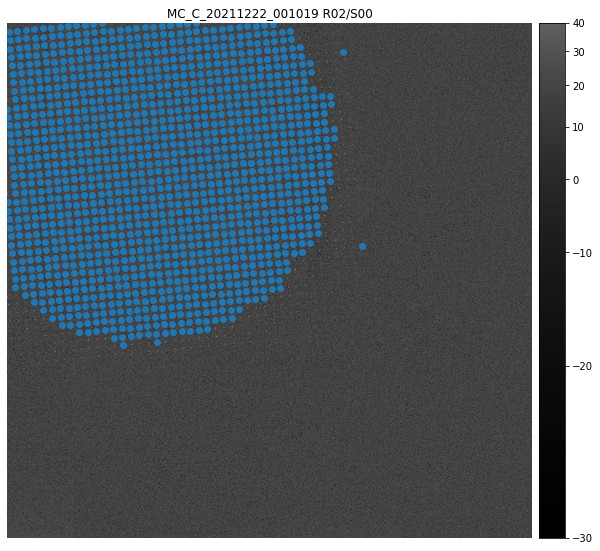

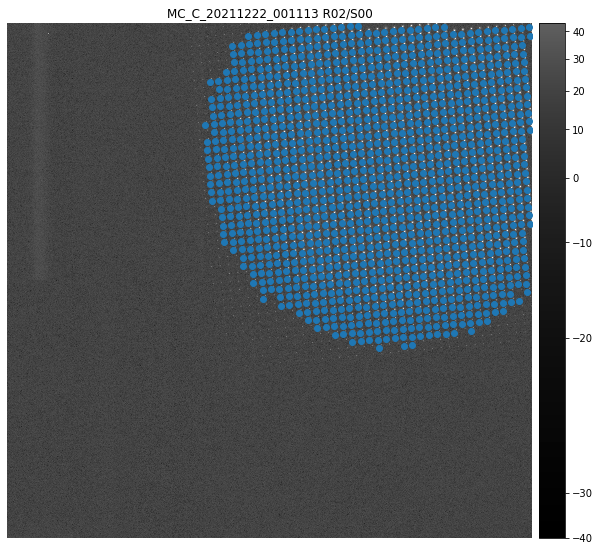

In [199]:
where = """
instrument='LSSTCam'
and detector=9
and exposure.observation_type = 'spot'
and exposure.exposure_time = 1.25
and exposure.science_program IN ('13230','13231')
"""

# gridSpotSrc

datasetRefs = list(subregistry.queryDatasets(
    datasetType="postISRCCD",
    collections=collections,
    where=where)
                  )
subresults = []

for aref in datasetRefs[:5]:
    try:
        # get a catalog from the butler
        raw = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
        img = raw.getImage().getArray()
#        print(src.asAstropy()["base_SdssCentroid_x","base_SdssCentroid_y","base_SdssShape_instFlux"])
        md = raw.getMetadata()
        x=src.asAstropy()["spotgrid_x"]
        y=src.asAstropy()["spotgrid_y"]
        I=src.asAstropy()["base_SdssShape_instFlux"]        
        display(raw)
        pylab.title(f"{md['OBSID']} {md['RAFTBAY']}/{md['CCDSLOT']}")
        pylab.plot(x,y,"o")        
        pylab.show()

        print(md["EXPTIME"])
        # stores into memory for later use
        subresults.append( {"md": md, "src":src} )
    except:
#        raise
        pass


In [179]:
x = src.asAstropy()["base_SdssCentroid_x","base_SdssCentroid_y""base_SdssShape_instFlux"].as_array()

In [194]:
list(md)

['DATE',
 'MJD',
 'RUNNUM',
 'CCD_MANU',
 'CCD_TYPE',
 'TESTTYPE',
 'IMGTYPE',
 'BINX',
 'BINY',
 'CCDGAIN',
 'CCDNOISE',
 'DATE-TRG',
 'MJD-TRG',
 'IMAGETAG',
 'CCDSLOT',
 'RAFTBAY',
 'FIRMWARE',
 'PLATFORM',
 'CONTNUM',
 'DAQVERS',
 'DAQPART',
 'DAQFOLD',
 'DAQANNOT',
 'OBSID',
 'TELCODE',
 'CONTRLLR',
 'DAYOBS',
 'SEQNUM',
 'HEADVER',
 'INSTRUME',
 'TELESCOP',
 'TSTAND',
 'SEQFILE',
 'SEQCKSUM',
 'LSST_NUM',
 'CCD_SERN',
 'REBNAME',
 'RAFTNAME',
 'TSEQNUM',
 'BOTXCAM',
 'BOTYCAM',
 'BOTX',
 'BOTY',
 'EXPTIME2',
 'FPVERS',
 'IHVERS',
 'CHANNEL',
 'CCDSUM',
 'DETSEC',
 'DETSIZE',
 'DTV1',
 'DTV2',
 'DTM1_1',
 'DTM2_2',
 'DTM1_2',
 'DTM2_1',
 'WCSNAMEA',
 'PC1_1A',
 'PC1_2A',
 'PC2_1A',
 'PC2_2A',
 'CDELT1A',
 'CDELT2A',
 'WCSNAMEC',
 'CTYPE1C',
 'CTYPE2C',
 'PC1_1C',
 'PC1_2C',
 'PC2_1C',
 'PC2_2C',
 'CDELT1C',
 'CDELT2C',
 'CRPIX1C',
 'CRPIX2C',
 'CRVAL1C',
 'CRVAL2C',
 'WCSNAMER',
 'CTYPE1R',
 'CTYPE2R',
 'PC1_1R',
 'PC1_2R',
 'PC2_1R',
 'PC2_2R',
 'CDELT1R',
 'CDELT2R',
 'CRPIX1R',